In [9]:
import pandas as pd
import math
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
import networkx as nx
import folium
import numpy as np

In [10]:
pip install diffprivlib

Note: you may need to restart the kernel to use updated packages.


In [11]:

from diffprivlib.mechanisms import Laplace

In [12]:
checkins = pd.read_csv("/kaggle/input/dataset-1/Gowalla_totalCheckins.txt",delimiter = '\t',names=["user", "check-in time", "latitude", "longitude", "location id"])

In [13]:
edge = pd.read_csv("/kaggle/input/dataset/Gowalla_edges.txt",delimiter='\t',names =['user','friend'])

In [14]:
checkins

user         check-in time   latitude  longitude  location id
0             0  2010-10-19T23:55:27Z  30.235909 -97.795140        22847
1             0  2010-10-18T22:17:43Z  30.269103 -97.749395       420315
2             0  2010-10-17T23:42:03Z  30.255731 -97.763386       316637
3             0  2010-10-17T19:26:05Z  30.263418 -97.757597        16516
4             0  2010-10-16T18:50:42Z  30.274292 -97.740523      5535878
...         ...                   ...        ...        ...          ...
6442887  196578  2010-06-11T13:32:26Z  51.742988  -0.488065       906885
6442888  196578  2010-06-11T13:26:45Z  51.746492  -0.490780       965121
6442889  196578  2010-06-11T13:26:34Z  51.741916  -0.496729      1174322
6442890  196585  2010-10-08T21:01:49Z  50.105516   8.571525       471724
6442891  196585  2010-10-07T17:39:18Z  50.027812   8.785098      4555073

[6442892 rows x 5 columns]

In [15]:
checkins.nunique()

user              107092
check-in time    5561957
latitude         1247095
longitude        1246818
location id      1280969
dtype: int64

In [16]:
edge.nunique()

user      196591
friend    196591
dtype: int64

In [17]:
edge.shape

(1900654, 2)

In [18]:

def haversine_distance(p1, p2):
    # Convert latitude and longitude from degrees to radians
    lat1 = p1[0]
    lon1 = p1[1]
    lat2 = p2[0]
    lon2 = p2[1]
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Earth radius
    earth_radius = 6371

    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = earth_radius_km * c

    return distance


In [19]:

# Create a DataFrame
gowalla_checkins_df = checkins

# Define the center coordinates for the three cities
city_centers = {
    'New York': (40.7128, -74.0060),
    'San Francisco': (37.7749, -122.4194),
    'Los Angeles': (34.0522, -118.2437)
}

# Filter users who performed at least 10 check-ins within 25 km radius
filtered_users = []
for user, group in gowalla_checkins_df.groupby('user'):
    user_location = (group['latitude'].mean(), group['longitude'].mean())
    for city, center in city_centers.items():
        distance_km = haversine_distance(user_location, center)
        if distance_km <= 25 and len(group) >= 10:
            filtered_users.append(user)

# Create a new DataFrame with filtered users
filtered_checkins = gowalla_checkins_df[gowalla_checkins_df['user'].isin(filtered_users)]



In [20]:
filtered_checkins.nunique()

user               1619
check-in time    105798
latitude          37707
longitude         37644
location id       38202
dtype: int64

In [21]:
filtered_edge = edge[(edge['user'].isin(filtered_checkins['user'])) & (edge['friend'].isin(filtered_checkins['user']))]

In [22]:
filtered_edge.shape

(1488, 2)

In [23]:
filtered_checkins.nunique()

user               1619
check-in time    105798
latitude          37707
longitude         37644
location id       38202
dtype: int64

In [24]:
# Extract relevant columns
n_checkins = filtered_checkins[['user', 'latitude', 'longitude']]

# Create a dictionary to store user check-ins
location_pattern = {}

# Iterate through each row
for index, row in n_checkins.iterrows():
    user_id = row['user']
    lat, lon = row['latitude'], row['longitude']
    
    # Add check-in to the user's set
    if user_id not in location_pattern:
        location_pattern[user_id] = []
    location_pattern[user_id].append((lat, lon))

In [25]:
# Print the location pattern dataset
cnt =0
for user, checkins_set in location_pattern.items():
    if cnt>5:
        break
    print(f"User {int(user)}: {checkins_set}")
    cnt+=1
    print()

User 25: [(37.7486019785, -122.3866948485), (37.7627594782, -122.4082749948), (37.7720367, -122.2357187333), (37.7649377167, -122.4122497333), (38.5827025, -121.48458655), (38.5799636056, -121.4935760756), (37.7731587, -122.2348441333), (37.7688843206, -122.2337985722), (37.8265767205, -122.2519954685), (37.7916932695, -122.4035525322), (37.7643505833, -122.2430120333), (37.7682808802, -122.424393842), (37.80861275, -122.26986), (37.8124280833, -122.2685821333), (37.8133514833, -122.268121), (37.7952588667, -122.2531805667), (37.7731587, -122.2348441333), (37.7819139667, -122.2381435833), (37.7764432286, -122.2264421126), (37.7625822667, -122.3960954167), (37.7625560167, -122.3960515167), (37.7569830429, -122.2497975826), (37.7574580545, -122.2507631779), (37.8265767205, -122.2519954685), (37.7574092333, -122.2493629333), (37.7926589201, -122.2569535809), (37.7625560167, -122.3960515167), (37.85361885, -122.2901058167), (37.76424725, -122.38684365), (37.7625560167, -122.3960515167), (3

In [26]:
# Extract relevant columns
latitude_values = filtered_checkins['latitude']
longitude_values = filtered_checkins['longitude']
user_id  = filtered_checkins['user']

# Calculate minimum and maximum values
min_lat = min(latitude_values)
max_lat = max(latitude_values)

min_lon = min(longitude_values)
max_lon = max(longitude_values)

min_id = min(user_id)
max_id  = max(user_id)

print(f"Minimum Latitude: {min_lat:.6f}")
print(f"Maximum Latitude: {max_lat:.6f}")

print(f"Minimum Longitude: {min_lon:.6f}")
print(f"Maximum Longitude: {max_lon:.6f}")


Minimum Latitude: 21.044134
Maximum Latitude: 51.469754
Minimum Longitude: -157.831070
Maximum Longitude: -0.460675


In [27]:
# Create a new container for normalized location data
norm_location_pattern = {}

# Take only the first 6 locations for each user
for user, checkins_list in location_pattern.items():
    norm_location_pattern[user] = checkins_list[:6]
    location_pattern[user]=checkins_list[:6]

# Normalize latitude and longitude values between 0 and 1
for user, checkins_list in norm_location_pattern.items():
    for i, (lat, lon) in enumerate(checkins_list):
        normalized_lat = (lat - min_lat) / (max_lat - min_lat)
        normalized_lon = (lon - min_lon) / (max_lon - min_lon)
        norm_location_pattern[user][i] = (normalized_lat, normalized_lon)

In [28]:
len(location_pattern)

1619

In [29]:
# Print the location pattern dataset
cnt =0
for user, checkins_set in location_pattern.items():
    if cnt>5:
        break
    print(f"User {int(user)}: {checkins_set}")
    print()
    cnt+=1

User 25: [(37.7486019785, -122.3866948485), (37.7627594782, -122.4082749948), (37.7720367, -122.2357187333), (37.7649377167, -122.4122497333), (38.5827025, -121.48458655), (38.5799636056, -121.4935760756)]

User 82: [(37.7907800667, -122.3891674333), (37.7939993574, -122.3959887028), (37.4860199222, -122.2299277782), (37.5686813362, -122.3243844509), (37.5363449238, -122.3000331514), (37.5336492833, -122.33711215)]

User 129: [(37.5660762333, -122.3240920667), (37.4863519422, -122.2290372849), (37.7767943797, -122.3948050219), (37.8052425333, -122.4338936667), (37.7715678667, -122.4302660167), (37.7712066235, -122.4302458763)]

User 200: [(37.7896260359, -122.397713704), (37.8098517635, -122.3664951324), (37.8098026167, -122.3661905), (37.8122746, -122.3627126), (37.8729563477, -122.2519111633), (37.8719868667, -122.2580188167)]

User 235: [(37.7405678203, -122.4345266819), (37.7855207387, -122.4018788338), (37.7855207387, -122.4018788338), (37.7864788714, -122.403563261), (37.78616910

In [30]:
# Convert location_pattern to a list of tuples
data = [(user, *coords) for user, checkins_list in norm_location_pattern.items() for coords in checkins_list]

# Create a DataFrame from the data
columns = ['user', 'latitude', 'longitude']
df = pd.DataFrame(data, columns=columns)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=1,n_init=10)
df['cluster'] = kmeans.fit_predict(df[['latitude', 'longitude']])

In [31]:
df

user  latitude  longitude  cluster
0         25.0  0.549026   0.225229        2
1         25.0  0.549492   0.225092        2
2         25.0  0.549797   0.226188        2
3         25.0  0.549563   0.225067        2
4         25.0  0.576441   0.230961        2
...        ...       ...        ...      ...
9709  196189.0  0.419866   0.253844        1
9710  196189.0  0.434558   0.248049        1
9711  196189.0  0.429068   0.251029        1
9712  196189.0  0.428769   0.251006        1
9713  196189.0  0.419644   0.253619        1

[9714 rows x 4 columns]

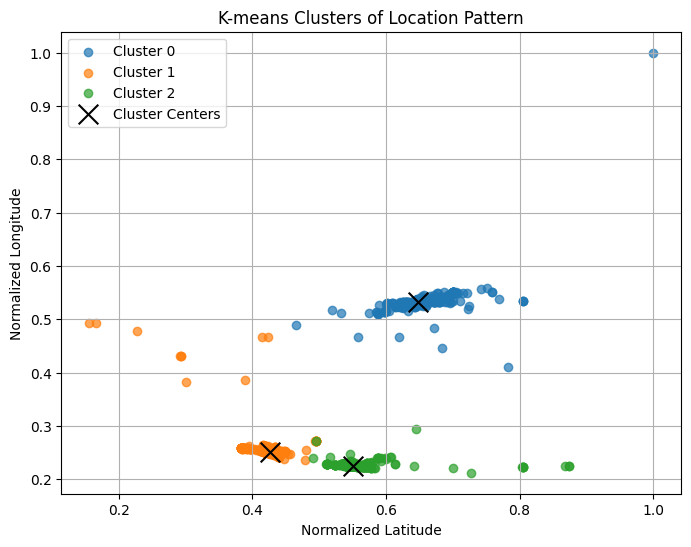

In [32]:
# Plot the resulting clusters
plt.figure(figsize=(8, 6))
for cluster in range(3):
    plt.scatter(df[df['cluster'] == cluster]['latitude'],
                df[df['cluster'] == cluster]['longitude'],
                label=f'Cluster {cluster}', alpha=0.7)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            color='black', marker='x', s=200, label='Cluster Centers')
plt.xlabel('Normalized Latitude')
plt.ylabel('Normalized Longitude')
plt.title('K-means Clusters of Location Pattern')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
len(location_pattern)

1619

In [34]:
kmeans.cluster_centers_

array([[0.64795326, 0.53275985],
       [0.42655039, 0.25203572],
       [0.55043767, 0.22546953]])

In [35]:
laplace = Laplace(epsilon=0.5, sensitivity=0.005)

In [36]:
import numpy as np

In [37]:
laplace_centre = np.empty(kmeans.cluster_centers_.shape)
for i in range(kmeans.cluster_centers_.shape[0]):
    laplace_centre[i] = [laplace.randomise(kmeans.cluster_centers_[i][0]), laplace.randomise(kmeans.cluster_centers_[i][1])]


In [38]:
laplace_centre

array([[0.64368622, 0.52131061],
       [0.41661606, 0.26319173],
       [0.54904001, 0.20647283]])

In [39]:
print("Laplace Perturbed Centre (µe):")
print(laplace_centre)
print("\nOriginal Centers:")
print(kmeans.cluster_centers_)

Laplace Perturbed Centre (µe):
[[0.64368622 0.52131061]
 [0.41661606 0.26319173]
 [0.54904001 0.20647283]]

Original Centers:
[[0.64795326 0.53275985]
 [0.42655039 0.25203572]
 [0.55043767 0.22546953]]


In [40]:
checkins = checkins.groupby('user')

In [41]:
filtered_edge

user  friend
6600         25    4425
6610         25    5060
6617         25    5067
11402        82     473
11424        82     742
...         ...     ...
1887259  188619  153607
1888079  189147  156515
1888245  189269  157196
1888431  189319  157350
1892365  191670  168573

[1488 rows x 2 columns]

In [42]:
location_array = {key: np.array(value) for key, value in norm_location_pattern.items()}

In [43]:
def haversine_distance(coords1, coords2):
    lat1, lon1 = np.radians(coords1[:, 0]), np.radians(coords1[:, 1])
    lat2, lon2 = np.radians(coords2[:, 0]), np.radians(coords2[:, 1])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    R = 6371  # Radius of the Earth in kilometers
    distance = R * c
    return np.mean(distance)

# Convert filtered_checkins dictionary to numpy array
location_array = {int(k): np.array(v) for k, v in norm_location_pattern.items()}

# Calculate average distances between each user and their friends
average_distances = {}
for user1, coords1 in location_array.items():
    user_avg_distances = {}
    for user2, coords2 in location_array.items():
        if user1 != user2:  # Skip calculating distance to oneself
            avg_distance = haversine_distance(coords1, coords2)  # Calculate average distance to each friend
            user_avg_distances[user2] = avg_distance
    average_distances[user1] = user_avg_distances



In [44]:
count = 0
for user, coords in location_array.items():
    print(f"User {user}: {coords}")
    count += 1
    if count >5:
        break


User 25: [[0.54902637 0.22522899]
 [0.54949169 0.22509186]
 [0.5497966  0.22618836]
 [0.54956328 0.22506661]
 [0.57644078 0.23096138]
 [0.57635077 0.23090426]]
User 82: [[0.55041264 0.22521328]
 [0.55051845 0.22516994]
 [0.54039608 0.22622516]
 [0.54311291 0.22562494]
 [0.54205011 0.22577968]
 [0.54196151 0.22554406]]
User 129: [[0.54302729 0.2256268 ]
 [0.54040699 0.22623082]
 [0.54995297 0.22517746]
 [0.55088798 0.22492907]
 [0.54978119 0.22495212]
 [0.54976932 0.22495225]]
User 200: [[0.55037471 0.22515897]
 [0.55103947 0.22535735]
 [0.55103785 0.22535929]
 [0.5511191  0.22538139]
 [0.55311353 0.22608547]
 [0.55308167 0.22604666]]
User 235: [[0.54876231 0.22492505]
 [0.55023978 0.22513251]
 [0.55023978 0.22513251]
 [0.55027127 0.2251218 ]
 [0.55026109 0.22513103]
 [0.55021456 0.22511775]]
User 280: [[0.55014394 0.2250961 ]
 [0.54996262 0.22509125]
 [0.54955628 0.22512756]
 [0.54928777 0.22500993]
 [0.53815687 0.22752397]
 [0.53506428 0.22772182]]


In [45]:
average_distances[25][82]

1.62853174588805

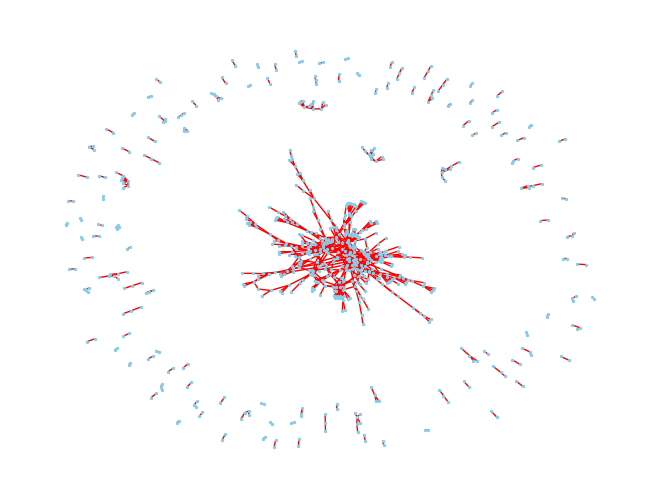

In [46]:
# Example graph creation
G = nx.Graph()
G.add_edges_from(filtered_edge.values)  # Assuming filtered_edge is your DataFrame containing user and friend columns

# Draw the graph
nx.draw(G, node_color='skyblue', node_size=2, edge_color='red')

# Show the plot
plt.show()


In [47]:
# Assuming G is your graph
total_edges = G.number_of_edges()
print("Total number of edges:", total_edges)


Total number of edges: 744


In [48]:
# Step 1: Calculate average location for each user
average_locations = {}
for user, locations in location_pattern.items():
    avg_lat = sum(lat for lat, lon in locations) / len(locations)
    avg_lon = sum(lon for lat, lon in locations) / len(locations)
    average_locations[user] = (avg_lat, avg_lon)

# Step 2: Create NetworkX graph
G = nx.Graph()
G.add_edges_from(filtered_edge.values)

# Step 3: Add node attributes for average locations
nx.set_node_attributes(G, average_locations, 'pos')

# Step 4: Plot using Folium
m = folium.Map(location=[40.7128, -74.0060], zoom_start=10)  # Centered at New York

# Iterate through edges
for u, v in G.edges():
    if G.has_edge(u, v):
        # Get positions of connected nodes
        pos_u = nx.get_node_attributes(G, 'pos')[u]
        pos_v = nx.get_node_attributes(G, 'pos')[v]
        # Add edge with light yellow color
        folium.PolyLine(locations=[pos_u, pos_v], color='red', weight=0.5).add_to(m)

# Add nodes with blue color
for node, pos in nx.get_node_attributes(G, 'pos').items():
    folium.CircleMarker(location=pos, radius=1.5, color='blue').add_to(m)

# Save the map
m.save('graph.html')


In [49]:
m

In [50]:
city_bounds = {
    'New York': [(40.4774, -74.2591), (40.9176, -73.7004)],  # Latitude and longitude boundaries of New York
    'Los Angeles': [(33.7034, -118.5506), (34.3373, -118.1553)],  # Latitude and longitude boundaries of Los Angeles
    'San Francisco': [(37.6398, -123.1738), (37.9298, -122.2818)]  # Latitude and longitude boundaries of San Francisco
}


# Define the number of rows and columns for the grid
num_rows = 20
num_cols = 20

# Create the grid for each city and add it to the map
for city, bounds in city_bounds.items():
    lat_range = bounds[1][0] - bounds[0][0]
    lon_range = bounds[1][1] - bounds[0][1]
    lat_step = lat_range / num_rows
    lon_step = lon_range / num_cols
    
    for i in range(num_rows):
        for j in range(num_cols):
            # Calculate the latitude and longitude coordinates for the grid cell
            lat = bounds[0][0] + i * lat_step
            lon = bounds[0][1] + j * lon_step
            # Add a circle marker at each grid cell
            folium.CircleMarker(location=[lat, lon], radius=1, color='black').add_to(m)

# Save the map
m.save('grid.html')

In [51]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers

    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Calculate differences in latitude and longitude
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Calculate Haversine distance
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance

In [52]:
average_locations = {}
for user, locations in location_pattern.items():
    avg_lat = sum(lat for lat, lon in locations) / len(locations)
    avg_lon = sum(lon for lat, lon in locations) / len(locations)
    average_locations[user] = (avg_lat, avg_lon)


In [53]:
m

# Attack 1

In [54]:

def find_nearest_grid(point, grids):
    # Calculate distances to all grid points
    distances = [(grid, haversine(point[0], point[1], grid[0], grid[1])) for grid in grids]
    # Sort the distances and select the nearest 9 grids
    nearest_grid = sorted(distances, key=lambda x: x[1])[:9]
    return [grid for grid, _ in nearest_grid]


def find_max_user_grid(grid_counts):
    max_grid = max(grid_counts, key=grid_counts.get)
    return max_grid

def calculate_avg_users_in_grid(grid, user_locations):
    avg_users = [user_locations[user] for user, loc in user_locations.items() if grid in find_nearest_grid(loc, [grid])]

    if avg_users:
        return np.mean(avg_users, axis=0)
    else:
        return None

# Define grid dots for 20x20 grid in each city
grid_size = 20
city_bounds = {
    'New York': [(40.4774, -74.2591), (40.9176, -73.7004)],  # Latitude and longitude boundaries of New York
    'Los Angeles': [(33.7034, -118.5506), (34.3373, -118.1553)],  # Latitude and longitude boundaries of Los Angeles
    'San Francisco': [(37.6398, -123.1738), (37.9298, -122.2818)]  # Latitude and longitude boundaries of San Francisco
}
grids = []
for city, bounds in city_bounds.items():
    lat_range = bounds[1][0] - bounds[0][0]
    lon_range = bounds[1][1] - bounds[0][1]
    lat_step = lat_range / grid_size
    lon_step = lon_range / grid_size
    for i in range(grid_size):
        for j in range(grid_size):
            lat = bounds[0][0] + i * lat_step
            lon = bounds[0][1] + j * lon_step
            grids.append((lat, lon))

# Define average location of each user (for example)
# Estimate user locations
estimated_locations = {}
for user, avg_location in average_locations.items():
    other_locations = [loc for u, loc in average_locations.items() if u != user]
    avg_other_location = np.mean(other_locations, axis=0)
    estimated_locations[user] = avg_other_location

# Find the nearest grid dot for each estimated location
nearest_grids = {user: find_nearest_grid(loc, grids) for user, loc in estimated_locations.items()}

# Count the number of users in each grid for each user
max_user_grids = {}
for user, nearest_grid in nearest_grids.items():
    grid_counts = {grid: 0 for grid in grids}
    for grid in nearest_grid:
        grid_counts[grid] += 1
    max_user_grids[user] = find_max_user_grid(grid_counts)

# Calculate the average of all users in the grid containing the maximum number of users for each user
estimated_user_locations = {}
for user, max_user_grid in max_user_grids.items():
    estimated_user_locations[user] = calculate_avg_users_in_grid(max_user_grid, average_locations)


# # Save the map
m.save('user_location_map.html')


In [55]:
m

In [56]:
count = 0
for user, coords in nearest_grids.items():
    print(f"User {user}: {coords}")
    count += 1
    if count >5:
        break


User 25.0: [(34.305605, -118.175065), (34.27391, -118.175065), (34.305605, -118.19483), (34.242215, -118.175065), (34.27391, -118.19483), (34.305605, -118.214595), (34.21052, -118.175065), (34.242215, -118.19483), (34.27391, -118.214595)]
User 82.0: [(34.305605, -118.175065), (34.27391, -118.175065), (34.305605, -118.19483), (34.242215, -118.175065), (34.27391, -118.19483), (34.305605, -118.214595), (34.21052, -118.175065), (34.242215, -118.19483), (34.27391, -118.214595)]
User 129.0: [(34.305605, -118.175065), (34.27391, -118.175065), (34.305605, -118.19483), (34.242215, -118.175065), (34.27391, -118.19483), (34.305605, -118.214595), (34.21052, -118.175065), (34.242215, -118.19483), (34.27391, -118.214595)]
User 200.0: [(34.305605, -118.175065), (34.27391, -118.175065), (34.305605, -118.19483), (34.242215, -118.175065), (34.27391, -118.19483), (34.305605, -118.214595), (34.21052, -118.175065), (34.242215, -118.19483), (34.27391, -118.214595)]
User 235.0: [(34.305605, -118.175065), (34

In [57]:
count = 0
for user, coords in estimated_locations.items():
    print(f"User {user}: {coords}")
    count += 1
    if count >5:
        break

User 25.0: [  37.45984841 -105.4884483 ]
User 82.0: [  37.46010608 -105.48828807]
User 129.0: [  37.4600579  -105.48826069]
User 200.0: [  37.4599766  -105.48828534]
User 235.0: [  37.46000724 -105.48823949]
User 280.0: [  37.46009442 -105.48832071]


In [58]:
count = 0
for user, coords in average_locations.items():
    print(f"User {user}: {coords}")
    count += 1
    if count >5:
        break

User 25.0: (38.0351669965, -122.07018348925)
User 82.0: (37.61824581493334, -122.32943561110001)
User 129.0: (37.696206596450004, -122.37372332220001)
User 200.0: (37.827749705083335, -122.3338403194)
User 235.0: (37.77816844228334, -122.40802679711668)
User 280.0: (37.63710993788334, -122.27662254204999)


In [59]:
# Calculate distances for each user
distances = {user: haversine(estimated_locations[user][0], estimated_locations[user][1], 
                             average_locations[user][0], average_locations[user][1])
             for user in estimated_locations}

# Calculate the average distance
average_distance = np.mean(list(distances.values()))


print("\nAverage error in Distance:", average_distance)



Average error in Distance: 1788.3399732569264


# Attack 2

In [60]:
filtered_edge.groupby('user')

In [61]:

all_friends_dict = {}

# Iterate over each row in filtered_edge
for index, row in filtered_edge.iterrows():
    user = row['user']
    friend = row['friend']
    
    # Check if user is already in the dictionary, if not, add it
    if user not in all_friends_dict:
        all_friends_dict[user] = []
    
    # Add friend to the list of friends for the user
    all_friends_dict[user].append(friend)



In [62]:
def estimate_user_location(all_friends_dict, average_locations, city_bounds):
    # Initialize a dictionary to store the estimated locations of users
    estimated_locations1 = {}

    # Iterate over each user in all_friends_dict
    for user, friend_ids in all_friends_dict.items():
        max_city = None
        max_friends_count = 0
        
        # Count the number of friends in each city
        for city, bounds in city_bounds.items():
            city_friends_count = sum(1 for friend_id in friend_ids if bounds[0][0] <= average_locations.get(friend_id, (0, 0))[0] <= bounds[1][0] and bounds[0][1] <= average_locations.get(friend_id, (0, 0))[1] <= bounds[1][1])
            if city_friends_count > max_friends_count:
                max_friends_count = city_friends_count
                max_city = city
        
        # Calculate the estimated location based on the average of all friends' locations in the max city
        if max_city:
            friend_locations = [average_locations.get(friend_id) for friend_id in friend_ids if friend_id in average_locations and city_bounds[max_city][0][0] <= average_locations[friend_id][0] <= city_bounds[max_city][1][0] and city_bounds[max_city][0][1] <= average_locations[friend_id][1] <= city_bounds[max_city][1][1]]
            if friend_locations:
                estimated_location = np.mean(friend_locations, axis=0)
                estimated_locations1[user] = estimated_location

    return estimated_locations1


# Call the function to estimate user locations
estimated_locations1 = estimate_user_location(all_friends_dict, average_locations, city_bounds)


In [63]:
# Calculate distances for each user
distances1 = {}
for user, est_location in estimated_locations1.items():
    avg_location = average_locations.get(user)
    if est_location is not None and avg_location is not None:
        dist = haversine(est_location[0], est_location[1], avg_location[0], avg_location[1])
        distances1[user] = dist

# Calculate the average distance
average_distance1 = np.mean(list(distances1.values()))

print("\nAverage error in Distance:", average_distance1)



Average error in Distance: 232.54590955056898


# Generating synthetic data and using it

In [64]:
print(min_lat,max_lat)
print(min_lon,max_lon)
print(min_id,max_id)

21.0441344976 51.46975405
-157.8310704167 -0.46067515
25 196189


In [65]:
count = 0
for user, coords in average_locations.items():
    print(f"User {user}: {coords}")
    count += 1
    if count >5:
        break

User 25.0: (38.0351669965, -122.07018348925)
User 82.0: (37.61824581493334, -122.32943561110001)
User 129.0: (37.696206596450004, -122.37372332220001)
User 200.0: (37.827749705083335, -122.3338403194)
User 235.0: (37.77816844228334, -122.40802679711668)
User 280.0: (37.63710993788334, -122.27662254204999)


In [66]:
# cal. the mean lon,lat
latitudes = [coord[0] for coord in average_locations.values()]
longitudes = [coord[1] for coord in average_locations.values()]

mean_lat = sum(latitudes) / len(latitudes)
mean_lon = sum(longitudes) / len(longitudes)

In [67]:
num_records = 1000

# Get user IDs from the average_locations dictionary
user_ids = list(average_locations.keys())

# Generate synthetic data
data = {
    'User ID': random.sample(user_ids, k=num_records),  # Choose random user IDs for each record
    'Latitude': [random.uniform(mean_lat - (max_lat - min_lat)/2, mean_lat + (max_lat - min_lat)/2) for _ in range(num_records)],
    'Longitude': [random.uniform(mean_lon - (max_lon - min_lon)/2, mean_lon + (max_lon - min_lon)/2) for _ in range(num_records)]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display a sample of the synthetic data
print(df.head())


    User ID   Latitude   Longitude
0    8908.0  36.728719  -96.729577
1  124329.0  43.912421  -43.189295
2  156470.0  43.481562  -50.917534
3  124131.0  46.438586  -99.884856
4  188619.0  44.472716 -113.054864


In [68]:
syn_data = df.set_index('User ID').apply(tuple, axis=1).to_dict()


In [69]:
for user, loc in average_locations.items():
    if user not in syn_data:
        syn_data[user] = loc
    else:
        # Calculate the average of existing and new values
        syn_data[user] = np.mean([syn_data[user], loc], axis=0)

In [70]:
count = 0
for user, coords in syn_data.items():
    print(f"User {user}: {coords}")
    count += 1
    if count >5:
        break

User 8908.0: [  35.38640193 -107.5433967 ]
User 124329.0: [ 42.33544877 -58.59035309]
User 156470.0: [ 38.7564108 -84.6606161]
User 124131.0: [ 43.59361409 -86.90550608]
User 188619.0: [ 42.59071522 -93.51185188]
User 83722.0: [  43.33605421 -100.05925652]


# Attack 1 using syn_data

In [71]:
# Estimate user locations
estimated_locations = {}
for user, avg_location in syn_data.items():
    other_locations = [loc for u, loc in syn_data.items() if u != user]
    avg_other_location = np.mean(other_locations, axis=0)
    estimated_locations[user] = avg_other_location

# Find the nearest grid dot for each estimated location
nearest_grids = {user: find_nearest_grid(loc, grids) for user, loc in estimated_locations.items()}

# Count the number of users in each grid for each user
max_user_grids = {}
for user, nearest_grid in nearest_grids.items():
    grid_counts = {grid: 0 for grid in grids}
    for grid in nearest_grid:
        grid_counts[grid] += 1
    max_user_grids[user] = find_max_user_grid(grid_counts)

# Calculate the average of all users in the grid containing the maximum number of users for each user
estimated_user_locations = {}
for user, max_user_grid in max_user_grids.items():
    estimated_user_locations[user] = calculate_avg_users_in_grid(max_user_grid, syn_data)



In [72]:
# Calculate distances for each user
distances = {user: haversine(estimated_locations[user][0], estimated_locations[user][1], 
                             syn_data[user][0], syn_data[user][1])
             for user in estimated_locations}

# Calculate the average distance
average_distance = np.mean(list(distances.values()))


print("\nAverage error in Distance:", average_distance)



Average error in Distance: 1906.996575708789


# Attack 2 using syn data


In [73]:
# Call the function to estimate user locations
estimated_locations_syn = estimate_user_location(all_friends_dict, syn_data, city_bounds)


In [74]:
# Calculate distances for each user
distances1 = {}
for user, est_location in estimated_locations_syn.items():
    avg_location = syn_data.get(user)
    if est_location is not None and avg_location is not None:
        dist = haversine(est_location[0], est_location[1], avg_location[0], avg_location[1])
        distances1[user] = dist

# Calculate the average distance
average_distance1 = np.mean(list(distances1.values()))

print("\nAverage error in Distance:", average_distance1)



Average error in Distance: 1474.2413792156935


# 